# Avocado Price Prediction

The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados.

Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags.

The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

Some relevant columns in the dataset:

Date - The date of the observation AveragePrice - the average price of a single avocado type - conventional or organic year - the year Region - the city or region of the observation Total Volume - Total number of avocados sold 4046 - Total number of avocados with PLU 4046 sold 4225 - Total number of avocados with PLU 4225 sold 4770 - Total number of avocados with PLU 4770 sold

# Business problem
To make a model that can consider the data provided and predict the Average Price.

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
import joblib
from sklearn.decomposition import PCA
from scipy.stats import zscore

In [106]:
df=pd.read_csv('avocado.csv')
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [107]:
df.drop('Unnamed: 0', inplace=True,axis=1)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [108]:
df.shape

(18249, 13)

In [109]:
df.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region'],
      dtype='object')

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


Lets Check the NaN values

In [111]:
df.isna().sum()

Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

There is no Null values in the data Lets check for the correlation of the data

In [112]:
#checking the value counts of each type
df.type.value_counts()

conventional    9126
organic         9123
Name: type, dtype: int64

In [113]:
#correlation of total volume to total bag
df[['Total Volume','Total Bags']].corr()

,Total Volume,Total Bags
Total Volume,1.000000,0.963047
Total Bags,0.963047,1.000000


In [114]:
#checking the average year of volume of avacado per year
df.groupby('year')['Total Volume'].mean()

year
2015    7.810274e+05
2016    8.584206e+05
2017    8.623393e+05
2018    1.066928e+06
Name: Total Volume, dtype: float64

In [115]:
#checking the organic type of avacado 
organic = df[df['type'] == 'organic']
organic

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
9126,2015-12-27,1.83,989.55,8.16,88.59,0.00,892.80,892.80,0.00,0.0,organic,2015,Albany
9127,2015-12-20,1.89,1163.03,30.24,172.14,0.00,960.65,960.65,0.00,0.0,organic,2015,Albany
9128,2015-12-13,1.85,995.96,10.44,178.70,0.00,806.82,806.82,0.00,0.0,organic,2015,Albany
9129,2015-12-06,1.84,1158.42,90.29,104.18,0.00,963.95,948.52,15.43,0.0,organic,2015,Albany
9130,2015-11-29,1.94,831.69,0.00,94.73,0.00,736.96,736.96,0.00,0.0,organic,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [116]:
df.groupby('year')['AveragePrice'].mean()

year
2015    1.375590
2016    1.338640
2017    1.515128
2018    1.347531
Name: AveragePrice, dtype: float64

In [117]:
df.groupby('year')['type'].value_counts()

year  type        
2015  conventional    2808
      organic         2807
2016  conventional    2808
      organic         2808
2017  conventional    2862
      organic         2860
2018  conventional     648
      organic          648
Name: type, dtype: int64

In [118]:
#total no of sale in each year of  4 years
df.groupby('year')['Total Volume'].count()

year
2015    5615
2016    5616
2017    5722
2018    1296
Name: Total Volume, dtype: int64

In [119]:
df.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


Above data shows that, multiple outliers predsent mostly in XLargeBags.

WE WILL DIVIDE DATE COLUMN INTO TWO CATEGORIES WHICH WILL HELP IN OUR ANALYSIS

In [120]:
df.Date = pd.to_datetime(df.Date)
Day = df.Date.dt.day.to_frame()
month = df.Date.dt.month.to_frame()

Date= Day.join(month, how='right', lsuffix='_day', rsuffix="_month")
df = df.join(Date, how= "left")
df.drop("Date", inplace = True, axis = 1)
df

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Date_day,Date_month
0,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,27,12
1,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,20,12
2,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,13,12
3,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,6,12
4,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,29,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico,4,2
18245,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico,28,1
18246,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico,21,1
18247,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico,14,1


<AxesSubplot:xlabel='year', ylabel='AveragePrice'>

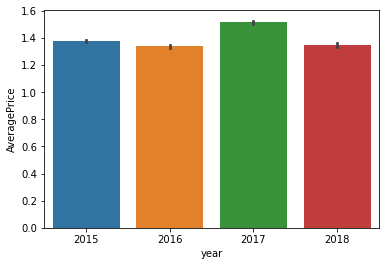

In [121]:
#checking for ratio of year and price.

sns.barplot(x='year', y='AveragePrice', data=df)

graph shows that in 2017 there was the maximum average price for avocado. 

<AxesSubplot:xlabel='Date_month', ylabel='AveragePrice'>

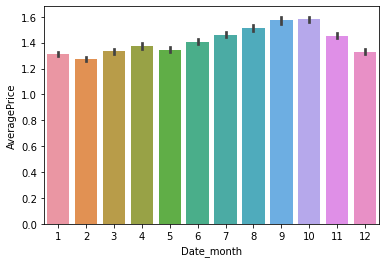

In [122]:
sns.barplot(x='Date_month', y='AveragePrice', data=df)

# Observation

In Year 2017, the price is maximum as compared to other year.

September and October had the maximum average price.

<AxesSubplot:xlabel='year', ylabel='AveragePrice'>

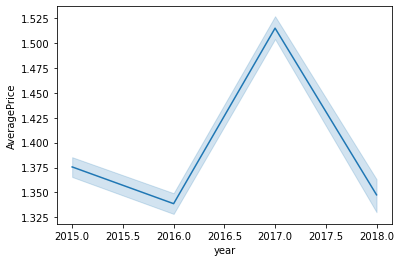

In [123]:
sns.lineplot(x = 'year', y = 'AveragePrice', data=df)

<AxesSubplot:xlabel='type', ylabel='AveragePrice'>

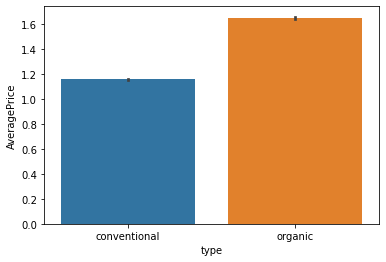

In [124]:
#checking ratio of type and price that which year had max average price
sns.barplot(x = "type" , y = "AveragePrice" ,data=df )

# As organic type of avacado is having the more price per unit then conventional

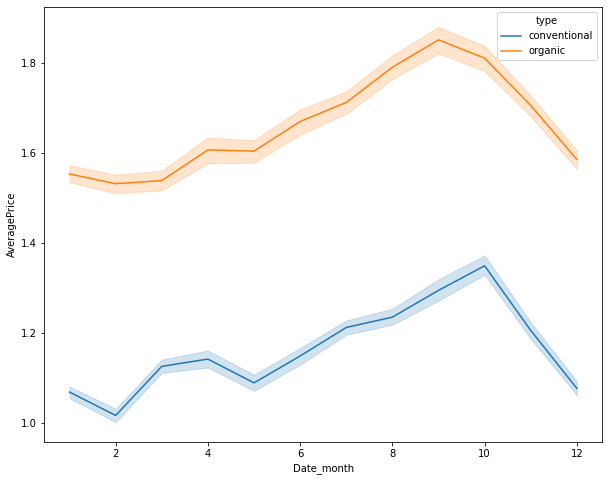

In [125]:
plt.figure(figsize=(10,8))
sns.lineplot(x='Date_month', y='AveragePrice',hue='type',data=df)
plt.show()

Above graph shown that there is hike between month 8-10 of both type of avacado

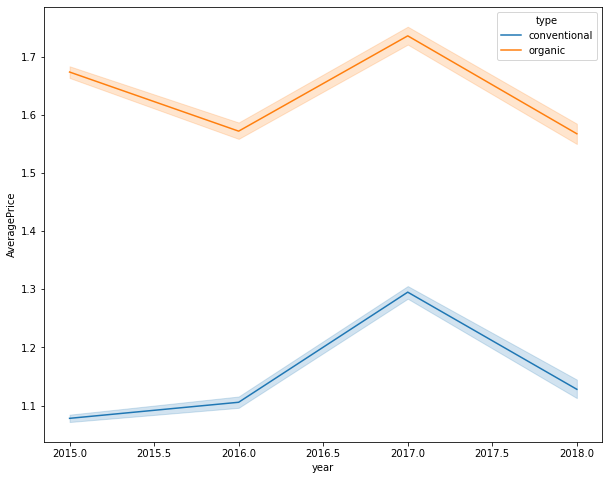

In [126]:
plt.figure(figsize=(10,8))
sns.lineplot(x='year', y='AveragePrice',hue='type',data=df)
plt.show()

# Observation

Average price of organic is higher than conventional and getting a peak on 2017 for both.

Text(0.5, 1.0, 'ration of Price and Region')

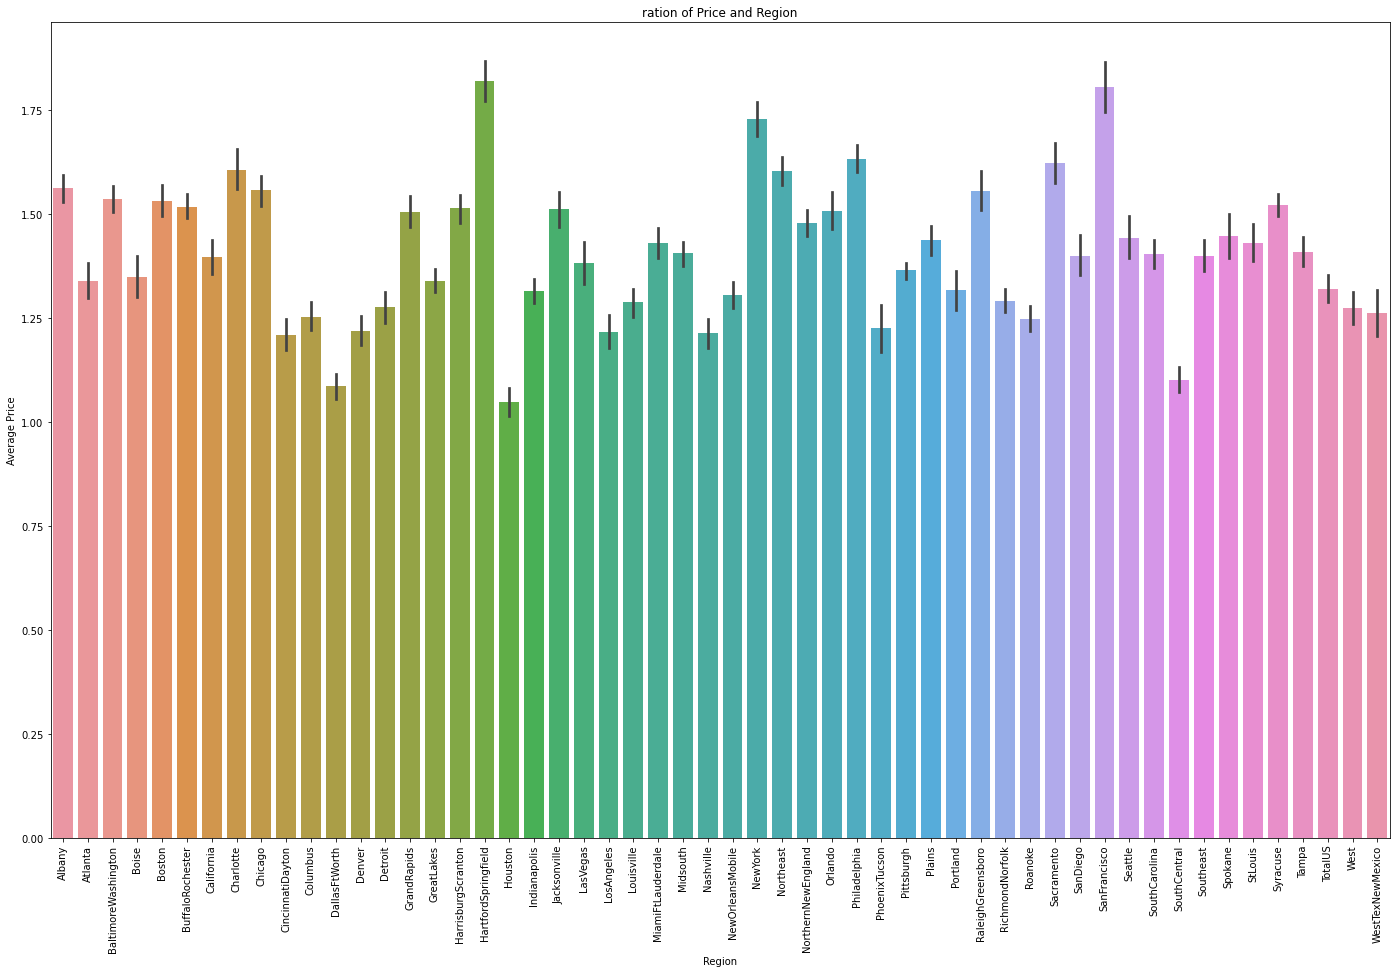

In [127]:
plt.figure(figsize=(24,15))
sns.barplot(x='region',y='AveragePrice',data=df)
plt.xticks(rotation=90)
plt.xlabel('Region')
plt.ylabel('Average Price')
plt.title('ration of Price and Region')

Above graph is showing that HartfordSpringfield ,SanFrancisco and NewYork are having more average price as compared to other region

Text(0.5, 1.0, 'Average_Price')

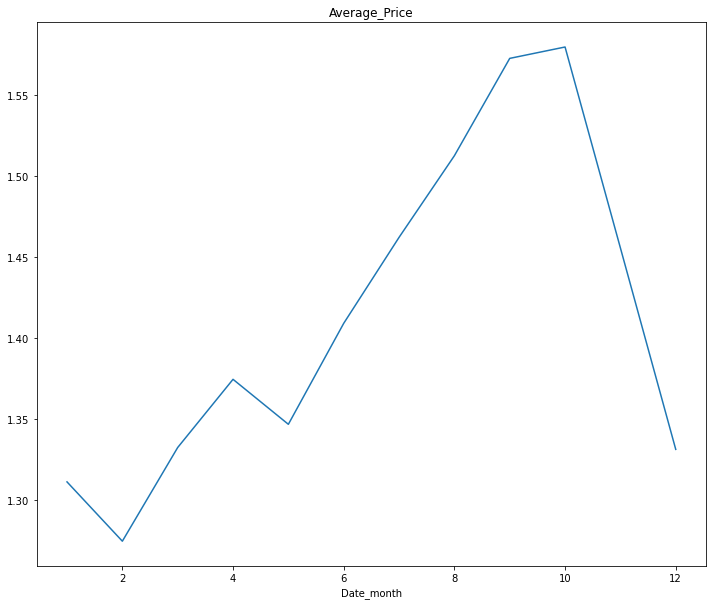

In [128]:
month=df.groupby('Date_month').mean()
plt.figure(figsize=(12,10))
month['AveragePrice'].plot()
plt.title('Average_Price')

In between august to october the price of avacado is much higher as comapared to other months

array([[<AxesSubplot:title={'center':'AveragePrice'}>,
        <AxesSubplot:title={'center':'Total Volume'}>,
        <AxesSubplot:title={'center':'4046'}>,
        <AxesSubplot:title={'center':'4225'}>],
       [<AxesSubplot:title={'center':'4770'}>,
        <AxesSubplot:title={'center':'Total Bags'}>,
        <AxesSubplot:title={'center':'Small Bags'}>,
        <AxesSubplot:title={'center':'Large Bags'}>],
       [<AxesSubplot:title={'center':'XLarge Bags'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'Date_day'}>,
        <AxesSubplot:title={'center':'Date_month'}>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

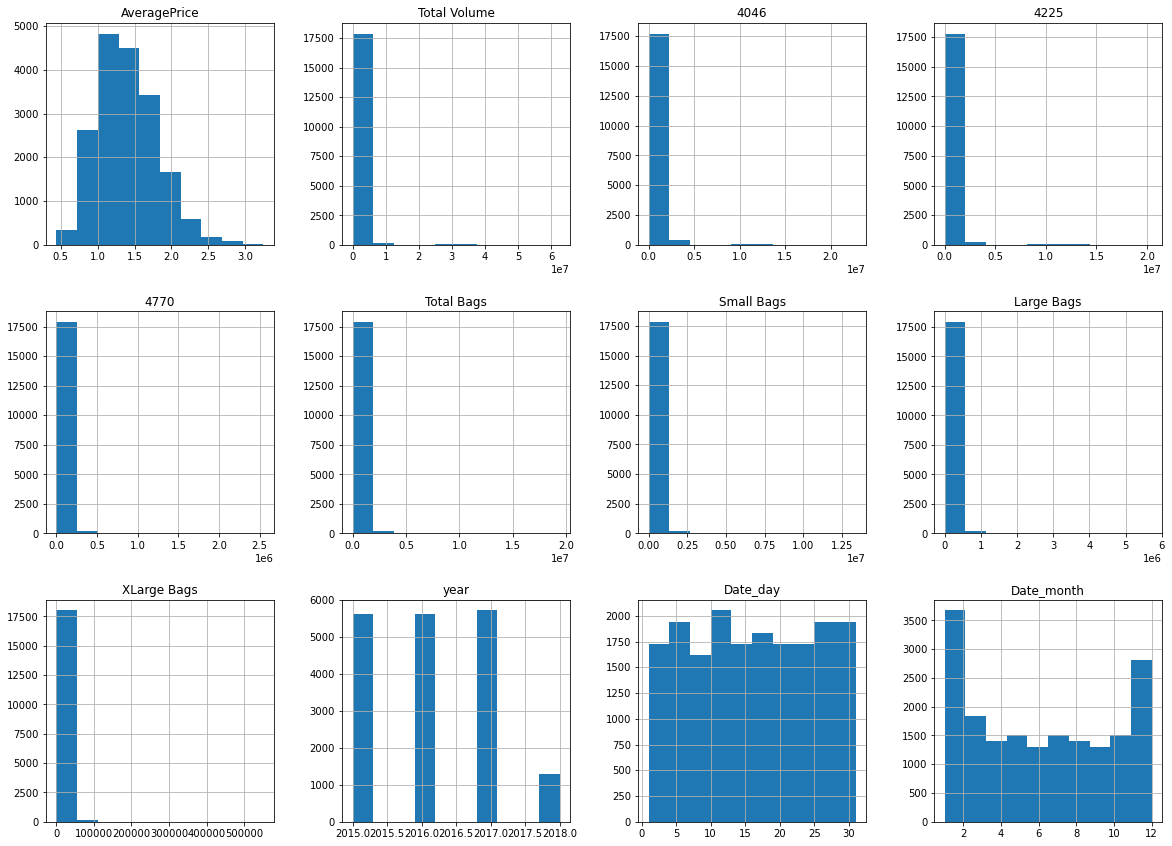

In [129]:
df.hist(figsize=(20,20),grid=True,layout=(4,4),bins=10)

# Observation

Average price column is normally distributing over the histogram.

# Checking for skewness

In [130]:
df.skew()

AveragePrice     0.580303
Total Volume     9.007687
4046             8.648220
4225             8.942466
4770            10.159396
Total Bags       9.756072
Small Bags       9.540660
Large Bags       9.796455
XLarge Bags     13.139751
year             0.215339
Date_day         0.014310
Date_month       0.106617
dtype: float64

Seems complete data is highly skewed.. Let's try to remove.

In [131]:
skew=('Total Volume','4046','4225','4770','Total Bags','Small Bags','Large Bags','XLarge Bags')
for col in skew:
    if df.skew().loc[col]>0.55:
        df[col]=np.log1p(df[col])

In [132]:
df.skew()

AveragePrice    0.580303
Total Volume    0.088098
4046           -0.328195
4225           -0.486654
4770            0.099986
Total Bags     -0.218874
Small Bags     -0.622148
Large Bags     -0.547765
XLarge Bags     1.176494
year            0.215339
Date_day        0.014310
Date_month      0.106617
dtype: float64

array([[<AxesSubplot:title={'center':'AveragePrice'}>,
        <AxesSubplot:title={'center':'Total Volume'}>,
        <AxesSubplot:title={'center':'4046'}>,
        <AxesSubplot:title={'center':'4225'}>],
       [<AxesSubplot:title={'center':'4770'}>,
        <AxesSubplot:title={'center':'Total Bags'}>,
        <AxesSubplot:title={'center':'Small Bags'}>,
        <AxesSubplot:title={'center':'Large Bags'}>],
       [<AxesSubplot:title={'center':'XLarge Bags'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'Date_day'}>,
        <AxesSubplot:title={'center':'Date_month'}>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

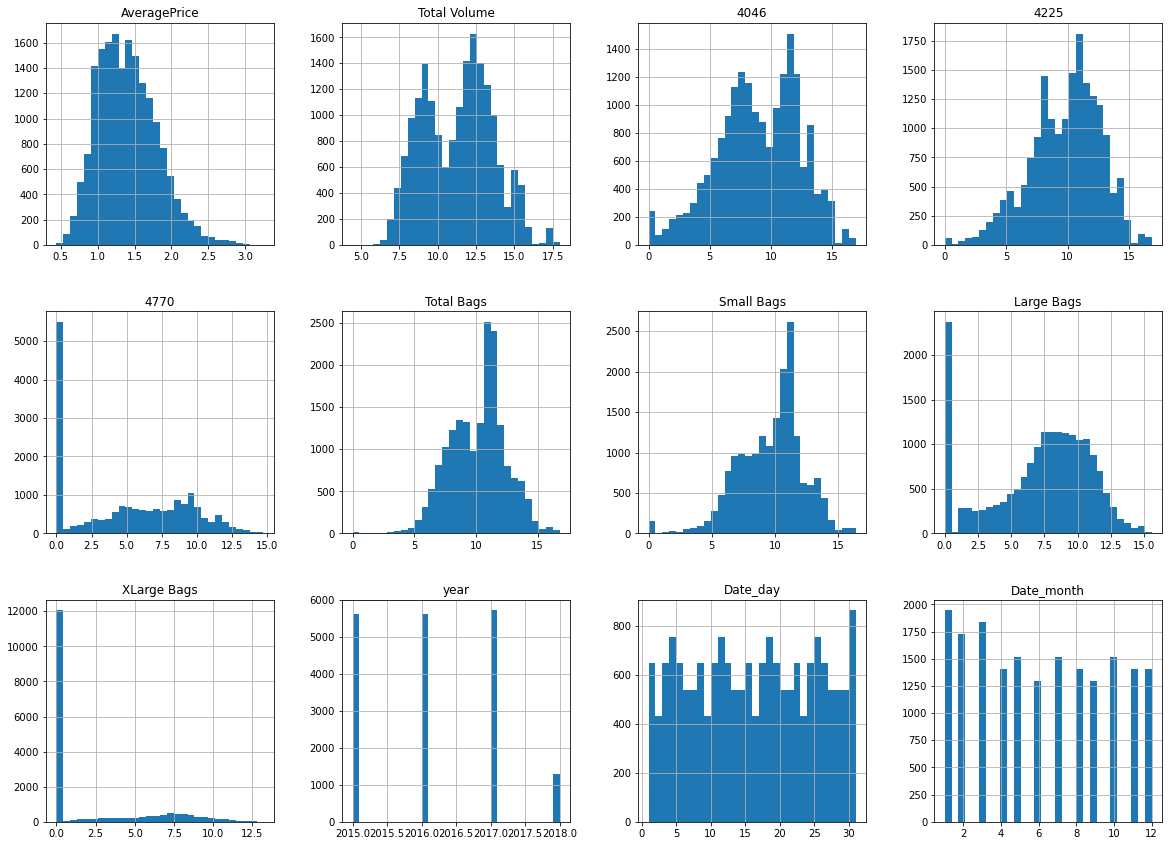

In [133]:
df.hist(figsize=(20,20), grid = True, layout = (4,4), bins = 30)

# Now checking for Outliers

AveragePrice        AxesSubplot(0.125,0.71587;0.133621x0.16413)
Total Volume     AxesSubplot(0.285345,0.71587;0.133621x0.16413)
4046              AxesSubplot(0.44569,0.71587;0.133621x0.16413)
4225             AxesSubplot(0.606034,0.71587;0.133621x0.16413)
4770             AxesSubplot(0.766379,0.71587;0.133621x0.16413)
Total Bags         AxesSubplot(0.125,0.518913;0.133621x0.16413)
Small Bags      AxesSubplot(0.285345,0.518913;0.133621x0.16413)
Large Bags       AxesSubplot(0.44569,0.518913;0.133621x0.16413)
XLarge Bags     AxesSubplot(0.606034,0.518913;0.133621x0.16413)
year            AxesSubplot(0.766379,0.518913;0.133621x0.16413)
Date_day           AxesSubplot(0.125,0.321957;0.133621x0.16413)
Date_month      AxesSubplot(0.285345,0.321957;0.133621x0.16413)
dtype: object

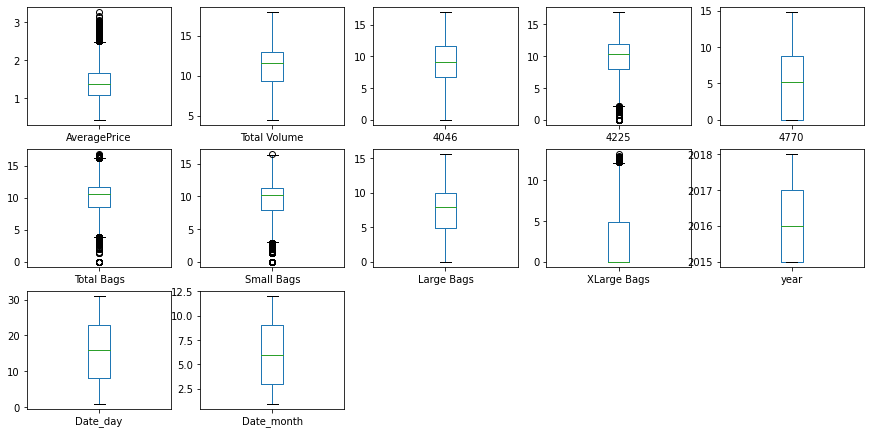

In [134]:
df.plot(kind='box',subplots=True, layout=(4,5), figsize=(15,10))

We can cleary see black dots denoting 'outliers'

let's remove them.

In [135]:
le=LabelEncoder()
list1=['region']
for val in list1:
    df[val]=le.fit_transform(df[val].astype(str))

In [136]:
le=LabelEncoder()
list2=['type']
for val in list2:
    df[val]=le.fit_transform(df[val].astype(str))

In [137]:
df

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Date_day,Date_month
0,1.33,11.070344,6.944801,10.905146,3.895080,9.070833,9.060055,4.545951,0.0,0,2015,0,27,12
1,1.35,10.912867,6.515127,10.706381,4.083115,9.159737,9.149429,4.589955,0.0,0,2015,0,20,12
2,0.93,11.680313,6.679222,11.600485,4.879007,9.005325,8.992584,4.645736,0.0,0,2015,0,13,12
3,1.08,11.277116,7.032624,11.184108,4.298373,8.667708,8.644425,4.903495,0.0,0,2015,0,6,12
4,1.28,10.840377,6.848515,10.688288,4.340944,8.729874,8.697389,5.291746,0.0,0,2015,0,29,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,1.63,9.745419,7.624599,7.333154,0.000000,9.510421,9.477908,6.070391,0.0,1,2018,53,4,2
18245,1.71,9.538855,7.083975,8.141044,0.000000,9.134090,9.098407,5.786284,0.0,1,2018,53,28,1
18246,1.87,9.530085,7.084159,7.805389,6.591591,9.147945,9.143431,3.768384,0.0,1,2018,53,21,1
18247,1.93,9.693150,7.332127,8.000363,6.590315,9.302969,9.298401,3.931826,0.0,1,2018,53,14,1


In [138]:
#calculate zscore

z=np.abs(zscore(df))
print(z)

       AveragePrice  Total Volume      4046      4225      4770  Total Bags  \
0          0.188689      0.107282  0.609752  0.374936  0.279143    0.494074   
1          0.139020      0.175949  0.737707  0.305200  0.233838    0.454761   
2          1.182069      0.158690  0.688840  0.618892  0.042078    0.523041   
3          0.809551      0.017121  0.583598  0.472808  0.181974    0.672335   
4          0.312861      0.207558  0.638425  0.298852  0.171717    0.644845   
...             ...           ...       ...       ...       ...         ...   
18244      0.556347      0.685006  0.407310  0.878279  1.217613    0.299689   
18245      0.755023      0.775077  0.568306  0.594835  1.217613    0.466102   
18246      1.152375      0.778901  0.568251  0.712597  0.370548    0.459975   
18247      1.301382      0.707798  0.494407  0.644192  0.370240    0.391424   
18248      0.531512      0.674542  0.304151  0.726698  0.087895    0.351204   

       Small Bags  Large Bags  XLarge Bags      typ

In [139]:
threshold=3
print(np.where(z<3))
print(df.shape)

(array([    0,     0,     0, ..., 18248, 18248, 18248], dtype=int64), array([ 0,  1,  2, ..., 11, 12, 13], dtype=int64))
(18249, 14)


In [140]:
#taking only values to df_new which are less than threshold - eliminating outlier values

df_new=df[(z<3).all(axis=1)]
df_new

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Date_day,Date_month
0,1.33,11.070344,6.944801,10.905146,3.895080,9.070833,9.060055,4.545951,0.0,0,2015,0,27,12
1,1.35,10.912867,6.515127,10.706381,4.083115,9.159737,9.149429,4.589955,0.0,0,2015,0,20,12
2,0.93,11.680313,6.679222,11.600485,4.879007,9.005325,8.992584,4.645736,0.0,0,2015,0,13,12
3,1.08,11.277116,7.032624,11.184108,4.298373,8.667708,8.644425,4.903495,0.0,0,2015,0,6,12
4,1.28,10.840377,6.848515,10.688288,4.340944,8.729874,8.697389,5.291746,0.0,0,2015,0,29,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,1.63,9.745419,7.624599,7.333154,0.000000,9.510421,9.477908,6.070391,0.0,1,2018,53,4,2
18245,1.71,9.538855,7.083975,8.141044,0.000000,9.134090,9.098407,5.786284,0.0,1,2018,53,28,1
18246,1.87,9.530085,7.084159,7.805389,6.591591,9.147945,9.143431,3.768384,0.0,1,2018,53,21,1
18247,1.93,9.693150,7.332127,8.000363,6.590315,9.302969,9.298401,3.931826,0.0,1,2018,53,14,1


In [141]:
print(df.shape)
print(df_new.shape)
df=df_new
print('shape after removing outliers',df.shape)

(18249, 14)
(17834, 14)
shape after removing outliers (17834, 14)


In [142]:
P1=(18249-17840)*100/18249
P1

2.2412186969148995

Removed outliers where zscore more than 3

Using Zscore method 2.24% outliers are removed which is ok. 

AveragePrice        AxesSubplot(0.125,0.71587;0.133621x0.16413)
Total Volume     AxesSubplot(0.285345,0.71587;0.133621x0.16413)
4046              AxesSubplot(0.44569,0.71587;0.133621x0.16413)
4225             AxesSubplot(0.606034,0.71587;0.133621x0.16413)
4770             AxesSubplot(0.766379,0.71587;0.133621x0.16413)
Total Bags         AxesSubplot(0.125,0.518913;0.133621x0.16413)
Small Bags      AxesSubplot(0.285345,0.518913;0.133621x0.16413)
Large Bags       AxesSubplot(0.44569,0.518913;0.133621x0.16413)
XLarge Bags     AxesSubplot(0.606034,0.518913;0.133621x0.16413)
type            AxesSubplot(0.766379,0.518913;0.133621x0.16413)
year               AxesSubplot(0.125,0.321957;0.133621x0.16413)
region          AxesSubplot(0.285345,0.321957;0.133621x0.16413)
Date_day         AxesSubplot(0.44569,0.321957;0.133621x0.16413)
Date_month      AxesSubplot(0.606034,0.321957;0.133621x0.16413)
dtype: object

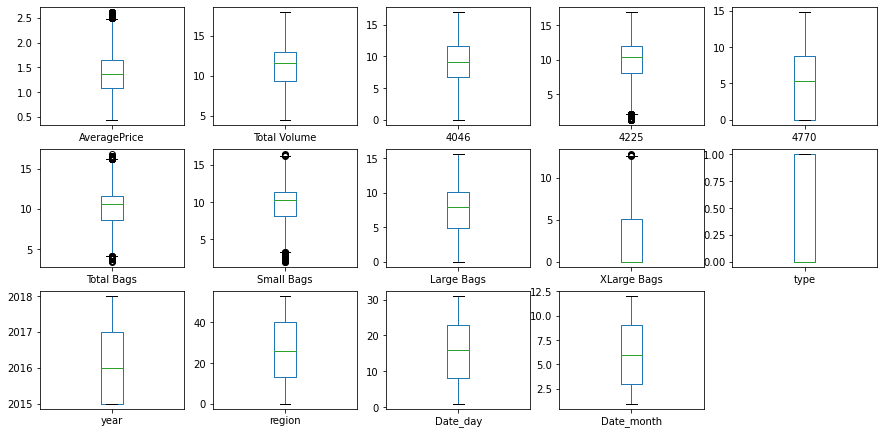

In [40]:
df.plot(kind='box',subplots=True, layout=(4,5), figsize=(15,10))

In [143]:
#now finding the mean value of each column 
print(df['4225'].mean())
print(df['Total Bags'].mean())
print(df['Small Bags'].mean())

9.904531114140678
10.267548476890832
9.83158716707478


In [144]:
#replace the outlier value to its mean value to remove outliers
df.loc[df['4225']<3,'4225'] = np.mean(df['4225'])
df.loc[df['Total Bags']<4.8,'Total Bags'] = np.mean(df['Total Bags'])
df.loc[df['Small Bags']<4,'Small Bags'] = np.mean(df['Small Bags'])

AveragePrice        AxesSubplot(0.125,0.71587;0.133621x0.16413)
Total Volume     AxesSubplot(0.285345,0.71587;0.133621x0.16413)
4046              AxesSubplot(0.44569,0.71587;0.133621x0.16413)
4225             AxesSubplot(0.606034,0.71587;0.133621x0.16413)
4770             AxesSubplot(0.766379,0.71587;0.133621x0.16413)
Total Bags         AxesSubplot(0.125,0.518913;0.133621x0.16413)
Small Bags      AxesSubplot(0.285345,0.518913;0.133621x0.16413)
Large Bags       AxesSubplot(0.44569,0.518913;0.133621x0.16413)
XLarge Bags     AxesSubplot(0.606034,0.518913;0.133621x0.16413)
type            AxesSubplot(0.766379,0.518913;0.133621x0.16413)
year               AxesSubplot(0.125,0.321957;0.133621x0.16413)
region          AxesSubplot(0.285345,0.321957;0.133621x0.16413)
Date_day         AxesSubplot(0.44569,0.321957;0.133621x0.16413)
Date_month      AxesSubplot(0.606034,0.321957;0.133621x0.16413)
dtype: object

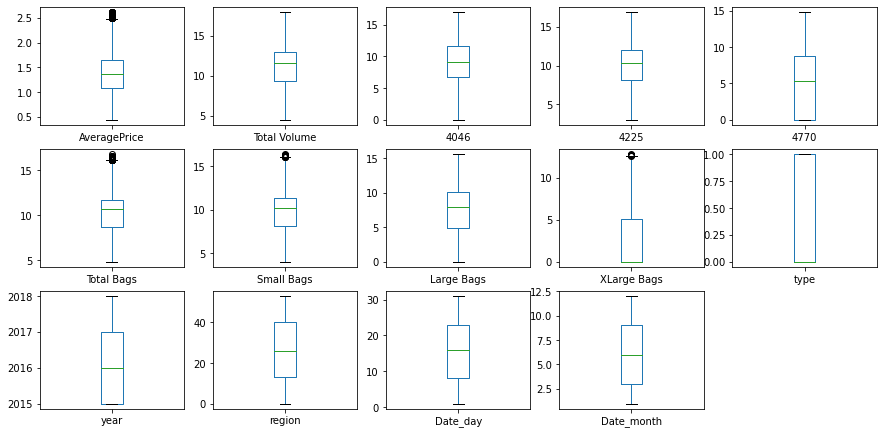

In [145]:
#plotting the boxplot of each column to check the outliers 
df.plot(kind='box',subplots = True,layout=(4,5),figsize = (15,10))

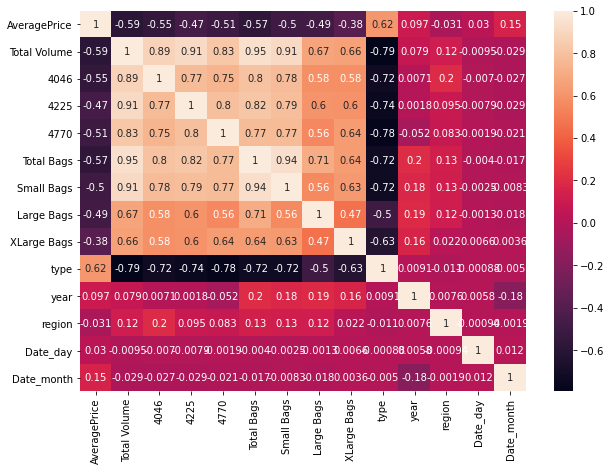

In [146]:
df_cor=df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(df_cor,annot=True)
plt.show()

In [147]:
x=df.drop(['AveragePrice'],axis=1)
x

,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Date_day,Date_month
0,11.070344,6.944801,10.905146,3.895080,9.070833,9.060055,4.545951,0.0,0,2015,0,27,12
1,10.912867,6.515127,10.706381,4.083115,9.159737,9.149429,4.589955,0.0,0,2015,0,20,12
2,11.680313,6.679222,11.600485,4.879007,9.005325,8.992584,4.645736,0.0,0,2015,0,13,12
3,11.277116,7.032624,11.184108,4.298373,8.667708,8.644425,4.903495,0.0,0,2015,0,6,12
4,10.840377,6.848515,10.688288,4.340944,8.729874,8.697389,5.291746,0.0,0,2015,0,29,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,9.745419,7.624599,7.333154,0.000000,9.510421,9.477908,6.070391,0.0,1,2018,53,4,2
18245,9.538855,7.083975,8.141044,0.000000,9.134090,9.098407,5.786284,0.0,1,2018,53,28,1
18246,9.530085,7.084159,7.805389,6.591591,9.147945,9.143431,3.768384,0.0,1,2018,53,21,1
18247,9.693150,7.332127,8.000363,6.590315,9.302969,9.298401,3.931826,0.0,1,2018,53,14,1


In [186]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit_transform(x)
x = pd.DataFrame(x,columns=x.columns)

In [149]:
y=pd.DataFrame(df['AveragePrice'])
y

,AveragePrice
0,1.33
1,1.35
2,0.93
3,1.08
4,1.28
...,...
18244,1.63
18245,1.71
18246,1.87
18247,1.93


Average price is a floating type. Thus this model will be a Regression type.

# Training Multiple Models

In [189]:
#Now by using multiple Algorithms we are calculating the best Algo which suit best for our data set 

model = [KNeighborsRegressor(),AdaBoostRegressor(),LinearRegression(),XGBRegressor()]
max_r2_score = 0
for r_state in range(40,90):
    train_x,test_x,train_y,test_y = train_test_split(x,y,random_state = r_state,test_size = 0.33)
    for i in model:
        i.fit(train_x,train_y)
        pre = i.predict(test_x)
        r2_sc = r2_score(test_y,pre)
        print("R2 score correspond to random state " ,r_state ,"is", r2_sc)
        if r2_sc> max_r2_score:
            max_r2_score=r2_sc
            final_state = r_state
            final_model = i
            
print()
print()
print()
print()
print("max R2 score correspond to random state " ,final_state , "is" , max_r2_score ,"and model is",final_model)

R2 score correspond to random state  40 is 0.6313061832613366
R2 score correspond to random state  40 is 0.5574632006792857
R2 score correspond to random state  40 is 0.5346454020424933
R2 score correspond to random state  40 is 0.8918156631550473
R2 score correspond to random state  41 is 0.6283544625458937
R2 score correspond to random state  41 is 0.572950867200045
R2 score correspond to random state  41 is 0.5539432477962569
R2 score correspond to random state  41 is 0.8892303228896703
R2 score correspond to random state  42 is 0.6232128841482094
R2 score correspond to random state  42 is 0.552389742628951
R2 score correspond to random state  42 is 0.5471134361611213
R2 score correspond to random state  42 is 0.895111637041851
R2 score correspond to random state  43 is 0.6358309089711458
R2 score correspond to random state  43 is 0.5408513552317916
R2 score correspond to random state  43 is 0.542848527285742
R2 score correspond to random state  43 is 0.8919448064623194
R2 score cor

In [191]:
#Checking the best parameter for prediction of XGBRegressor model using GridSearchCV
train_x,test_x,train_y,test_y = train_test_split(x,y,random_state = 74,test_size = 0.33)
xgb = XGB=XGBRegressor()
params={
    'booster':['gbtree','dart'],
    'importance_type':['gain','split'],
    'max_depth':[5,6,7],
    'n_estimators':[100,200,500]}
Grid=GridSearchCV(xgb,param_grid=params,n_jobs=-1,cv=5,scoring='r2')
Grid.fit(x,y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...ors=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
            

In [192]:
Grid.best_params_

{'booster': 'gbtree',
 'importance_type': 'gain',
 'max_depth': 5,
 'n_estimators': 500}

In [196]:
XBG = XGBRegressor(booster='gbtree', max_depth=5,importance_type='gain',n_estimators=500)
XBG.fit(train_x,train_y)
pred = XBG.predict(test_x)
r2_sc = r2_score(test_y,pred)
print("R2 Score :",r2_sc*100)

R2 Score : 90.0651485988271


<b>accuracy increased by 89.78 to 90.06</b>

In [197]:
XBG = XGBRegressor(
    booster='gbtree', 
    max_depth=5,
    importance_type='gain',
    n_estimators=500)

# Final Model Learning Curve

MODEL PERFORMANCE CURVE


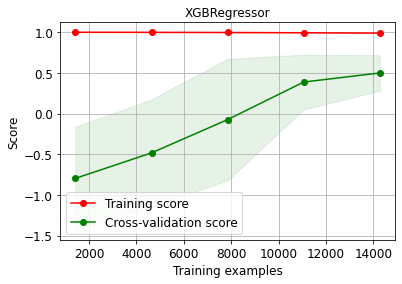

In [199]:
print('MODEL PERFORMANCE CURVE')
skplt.estimators.plot_learning_curve(XBG,x,y,cv=5,scoring='r2',title='XGBRegressor',text_fontsize='large')
plt.show()

Text(0, 0.5, 'Predicted_Y')

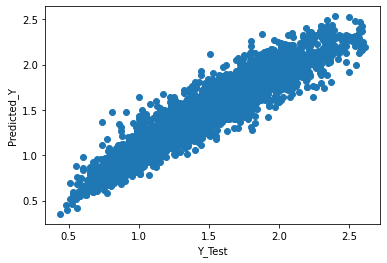

In [215]:
plt.scatter(x=test_y,y=pred)
plt.xlabel('Y_Test')
plt.ylabel('Predicted_Y')

In [209]:
XBG.fit(train_x,train_y)
y_predicted=XBG.predict(test_x)

# Final Model Metrics

In [211]:
print("Mean Squared Error",mean_squared_error(test_y,y_predicted))
print("Mean Absolute Error",mean_absolute_error(test_y,y_predicted))
print("RMSE",np.sqrt(mean_squared_error(test_y,y_predicted)))
print("R2 Score",r2_score(test_y,y_predicted))

Mean Squared Error 0.01496490702245183
Mean Absolute Error 0.08931648588427628
RMSE 0.12233113676595926
R2 Score 0.9006514859882709


# Saving Model

In [212]:
import joblib
joblib.dump(Grid,"Avocado.obj")

['Avocado.obj']

# Loading Model

In [213]:
model=joblib.load('Avocado.obj')

In [214]:
model.predict(x_test)

array([1.858379 , 1.858379 , 1.356763 , ..., 1.8595804, 1.2945555,
       1.2779425], dtype=float32)

# Conclusion

In this data the target variable was having the size of data 18249.

We did EDA to understand the importance of features and also did feature engineering 

It was found that many columns have high correlation with each other.

Trained multiple model and found XGBoostRegressor giving good r sqaure value so did hyperparameter tuning of that only.

At the end, build a model that can predict the average price of avacado.